In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', -1)

//anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

### Training Data

In [3]:
data = pd.read_csv("train_data.csv")
print(len(data.columns))
print(len(data))
print(data.head())

36
46708
   AdverseOpioidEvent DESYNPUF: End stage renal disease Indicator  \
0  0                   0                                            
1  0                   0                                            
2  0                   0                                            
3  0                   0                                            
4  0                   0                                            

   DESYNPUF: State Code  County Code  \
0  38                    170           
1  44                    460           
2  11                    381           
3  10                    280           
4  24                    710           

   Total number of months of part A coverage for the bene  \
0  12                                                       
1  12                                                       
2  12                                                       
3  12                                                       
4  12                         

#### Checking for missing values and filling in

In [4]:
missing_values_table(data)

Your selected dataframe has 36 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
MonthDiffFill,3459,7.4


In [5]:
data.MonthDiffFill.unique()

array([20.,  0., 16., nan, 21., 17., 15., 12., 23., 22.,  4., 28., 11.,
       10.,  5., 26., 30., 25., 13.,  9., 27., 18.,  8.,  7., 14., 34.,
        6., 19., 24.,  2., 29., 31.,  1., 32.,  3., 35., 33.])

In [6]:
data['MonthDiffFill'].fillna((data['MonthDiffFill'].mean()), inplace=True)

#### Checking for correlation

In [7]:
data.corr(method ='pearson') 

,AdverseOpioidEvent,DESYNPUF: State Code,County Code,Total number of months of part A coverage for the bene,Total number of months of part B coverage for the bene,Total number of months of part D plan coverage for the,Chronic Condition: Alzheimer or related disorders or s,Chronic Condition: Heart Failure,Chronic Condition: Chronic Kidney Disease,Chronic Condition: Cancer,Chronic Condition: Chronic Obstructive Pulmonary Disea,Chronic Condition: Depression,Chronic Condition: Diabetes,Chronic Condition: Ischemic Heart Disease,Chronic Condition: Osteoporosis,Chronic Condition: RA/OA,Chronic Condition: Stroke/transient Ischemic Attack,Inpatient annual Medicare reimbursement amount,Inpatient annual beneficiary responsibility amount,Inpatient annual primary payer reimbursement amount,Outpatient Institutional annual Medicare reimbursement,Outpatient Institutional annual beneficiary responsibi,Outpatient Institutional annual primary payer reimburs,Carrier annual Medicare reimbursement amount,Carrier annual beneficiary responsibility amount,Carrier annual primary payer reimbursement amount,RX_Filled,Total_Qty_Disp,Tot_Days_Sup,Patient_Pay,Tot_MME,Age,MonthDiffFill
AdverseOpioidEvent,1.000000,-0.002295,-0.000368,-0.002146,0.004538,-0.162026,0.072668,0.096172,0.106999,0.044235,0.103856,0.144885,0.118167,0.111842,0.063173,0.087729,0.039215,0.130305,0.166573,0.014836,0.074751,0.076164,0.011024,0.151515,0.145237,0.045168,-0.207817,-0.150588,-0.173932,-0.066722,-0.056409,-0.013656,-0.137290
DESYNPUF: State Code,-0.002295,1.000000,0.128331,0.001619,-0.011426,-0.005547,0.000216,-0.002982,-0.000436,0.009206,0.005392,0.010978,0.012283,0.004488,0.006043,0.002247,-0.001557,0.003895,0.008219,0.001555,0.000701,0.001445,0.007404,0.007951,0.006764,0.004681,0.001391,-0.005845,0.001363,-0.005020,0.002620,-0.021908,-0.002863
County Code,-0.000368,0.128331,1.000000,0.007593,0.006907,0.015548,0.003138,0.004170,0.008667,0.008003,0.007915,0.008647,0.018218,0.012925,0.004219,0.005873,-0.002221,0.004042,0.003393,0.010921,0.009505,0.007435,0.003704,0.013759,0.013915,-0.003967,0.046787,0.033949,0.038380,0.014938,0.016838,-0.015107,-0.015891
Total number of months of part A coverage for the bene,-0.002146,0.001619,0.007593,1.000000,0.172014,0.072581,0.017910,0.019575,0.011531,0.002208,0.009546,0.022190,0.027429,0.020497,0.005860,0.016570,0.003596,-0.002374,0.001610,0.002774,0.014928,0.013310,0.006057,0.023850,0.021108,0.008907,0.024841,0.019227,0.022647,0.011355,0.011078,0.005981,0.022088
Total number of months of part B coverage for the bene,0.004538,-0.011426,0.006907,0.172014,1.000000,0.111605,0.023906,0.029379,0.023688,0.006808,0.017921,0.029952,0.040791,0.036308,0.017312,0.020452,0.008315,0.006482,0.012656,0.000326,0.020455,0.021669,0.005718,0.033565,0.035391,0.010514,0.032792,0.028018,0.027631,0.018614,0.008096,0.011447,0.031283
Total number of months of part D plan coverage for the,-0.162026,-0.005547,0.015548,0.072581,0.111605,1.000000,0.004784,-0.000852,-0.010279,-0.021595,-0.006947,0.013904,0.001076,-0.016069,-0.018097,-0.009483,-0.002666,-0.023642,-0.027623,-0.015998,0.005177,0.005658,0.001333,-0.034953,-0.036638,-0.009201,0.168038,0.130982,0.142442,0.062619,0.045204,-0.012216,0.099797
Chronic Condition: Alzheimer or related disorders or s,0.072668,0.000216,0.003138,0.017910,0.023906,0.004784,1.000000,0.273387,0.247211,0.101174,0.226249,0.256417,0.305576,0.272634,0.158219,0.163206,0.143761,0.156698,0.197179,0.025021,0.145559,0.159282,0.015675,0.350269,0.345393,0.063419,0.035170,0.037017,0.031112,0.018691,0.010809,0.017898,0.012451
Chronic Condition: Heart Failure,0.096172,-0.002982,0.004170,0.019575,0.029379,-0.000852,0.273387,1.000000,0.349063,0.132904,0.310798,0.256160,0.394809,0.393973,0.190650,0.211164,0.162001,0.215321,0.242713,0.025418,0.199652,0.209712,0.032036,0.454246,0.445259,0.097639,0.039866,0.041376,0.027270,0.014202,0.002308,0.031023,0.017749
Chronic Condition: Chronic Kidney Disease,0.106999,-0.000436,0.008667,0.011531,0.023688,-0.010279,

In [8]:
#Removing high correlation columns

del data['Carrier annual Medicare reimbursement amount']
del data['Tot_Days_Sup']
del data['Total_Qty_Disp']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12047a1d0>,
      dtype=object)

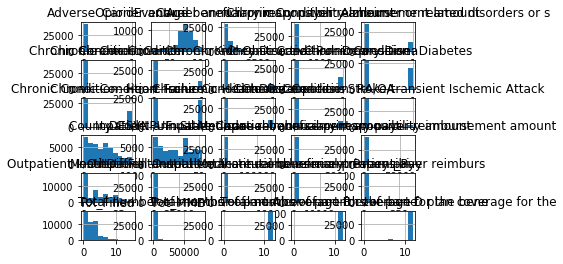

In [9]:
data.hist()

#### Encoding categorical variables

In [10]:
dataset = pd.get_dummies(data, columns = ['Sex', 'Race',"DESYNPUF: End stage renal disease Indicator"])

### Model build

#### Splitting the data into train/test at 65/35 ratio, and creating a stratefied sample to have propotionate labelled data

In [11]:
#Splitting the Train/Test data - 65-35 with strate
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.35)

print(dataset.shape)
print('########')
print("Train", train.shape)
print(train.groupby('AdverseOpioidEvent').count())
print('########')
print("Test", test.shape)
print(test.groupby('AdverseOpioidEvent').count())

(46708, 38)
########
Train (30360, 38)
                    DESYNPUF: State Code  County Code  \
AdverseOpioidEvent                                      
0                   28021                 28021         
1                   2339                  2339          

                    Total number of months of part A coverage for the bene  \
AdverseOpioidEvent                                                           
0                   28021                                                    
1                   2339                                                     

                    Total number of months of part B coverage for the bene  \
AdverseOpioidEvent                                                           
0                   28021                                                    
1                   2339                                                     

                    Total number of months of part D plan coverage for the  \
AdverseOpioidEvent          

#### Assiging the train and test data to Features variable and Label variable

In [12]:
y_train = train.iloc[:,0]
y_test = test.iloc[:,0]
X_train = train.drop('AdverseOpioidEvent', axis=1)
X_test = test.drop('AdverseOpioidEvent', axis=1)

In [13]:
X_train.columns

Index(['DESYNPUF: State Code', 'County Code',
       'Total number of months of part A coverage for the bene',
       'Total number of months of part B coverage for the bene',
       'Total number of months of part D plan coverage for the',
       'Chronic Condition: Alzheimer or related disorders or s',
       'Chronic Condition: Heart Failure',
       'Chronic Condition: Chronic Kidney Disease',
       'Chronic Condition: Cancer',
       'Chronic Condition: Chronic Obstructive Pulmonary Disea',
       'Chronic Condition: Depression', 'Chronic Condition: Diabetes',
       'Chronic Condition: Ischemic Heart Disease',
       'Chronic Condition: Osteoporosis', 'Chronic Condition: RA/OA',
       'Chronic Condition: Stroke/transient Ischemic Attack',
       'Inpatient annual Medicare reimbursement amount',
       'Inpatient annual beneficiary responsibility amount',
       'Inpatient annual primary payer reimbursement amount',
       'Outpatient Institutional annual Medicare reimbursement'

### Logistic Regression

In [14]:
lg = LogisticRegression()

In [15]:
lg_score = lg.fit(X_train,y_train)
lg_pred = lg_score.predict(X_test)
lg_preds_model_2 = np.where(lg_pred >= 0.5, 1, 0)

print(f'Model Accuracy: {lg_score.score(X_test, y_test)}')

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Accuracy: 0.9294714949840959


#### Random Forest

In [16]:
rf_scores = []
estimators = [300,200,500,400]
for i in estimators:
    rf_classifier = RandomForestClassifier(n_estimators = i, random_state = 0,max_depth = 50)
    rf_classifier.fit(X_train, y_train)
    rf_scores.append(rf_classifier.score(X_test, y_test))

In [17]:
print(f'Model Accuracy: {rf_classifier.score(X_test, y_test)}')

Model Accuracy: 0.9660508930756055


In [18]:
#fitting the model on in-sample test dataset, and converting the prediction to binary for confusionmatrix
preds_model_1 = rf_classifier.predict(X_test)
preds_model_2 = np.where(preds_model_1 >= 0.5, 1, 0)

In [19]:
print('Recall',recall_score(y_test, preds_model_2, average='binary'))
print('Precision',precision_score(y_test, preds_model_2, average='binary'))

Recall 0.5431993156544055
Precision 0.9679878048780488


#### Checking for Feature importance

In [20]:
rf_classifier.feature_importances_

array([0.05039609, 0.10101659, 0.00220952, 0.00189909, 0.02133823,
       0.0103318 , 0.00998528, 0.00887228, 0.00533163, 0.00880954,
       0.01917891, 0.00923556, 0.00934341, 0.00878648, 0.00913263,
       0.00487146, 0.03318382, 0.03398151, 0.00114069, 0.06037954,
       0.05172362, 0.00622149, 0.06395675, 0.02022918, 0.08838862,
       0.0213831 , 0.08348715, 0.05915929, 0.08770424, 0.03415938,
       0.03800656, 0.00750424, 0.0027558 , 0.00444686, 0.01127364,
       0.0050218 , 0.00515419])

In [21]:
# Selecting the top 20 features based on importance 
data_new = dataset[['AdverseOpioidEvent',
'Outpatient Institutional annual Medicare reimbursement',
'Chronic Condition: Alzheimer or related disorders or s',
'DESYNPUF: End stage renal disease Indicator_Y',
'Chronic Condition: Ischemic Heart Disease',
'Chronic Condition: Chronic Kidney Disease',
'Chronic Condition: Depression',
'Race_White',
'Inpatient annual Medicare reimbursement amount',
'Outpatient Institutional annual primary payer reimburs',
'Chronic Condition: Diabetes',
'Chronic Condition: Cancer',
'Sex_M',
'Tot_MME',
'DESYNPUF: State Code',
'Outpatient Institutional annual beneficiary responsibi',
'DESYNPUF: End stage renal disease Indicator_0',
'Chronic Condition: Osteoporosis',
'Chronic Condition: Chronic Obstructive Pulmonary Disea',
'Chronic Condition: Heart Failure',
'RX_Filled']]

In [22]:
#Splitting the Train/Test data - 65-35 with strate
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_new, test_size=0.35)

print(data_new.shape)
print('########')
print("Train", train.shape)
print(train.groupby('AdverseOpioidEvent').count())
print('########')
print("Test", test.shape)
print(test.groupby('AdverseOpioidEvent').count())

(46708, 21)
########
Train (30360, 21)
                    Outpatient Institutional annual Medicare reimbursement  \
AdverseOpioidEvent                                                           
0                   28078                                                    
1                   2282                                                     

                    Chronic Condition: Alzheimer or related disorders or s  \
AdverseOpioidEvent                                                           
0                   28078                                                    
1                   2282                                                     

                    DESYNPUF: End stage renal disease Indicator_Y  \
AdverseOpioidEvent                                                  
0                   28078                                           
1                   2282                                            

                    Chronic Condition: Ischemic Heart Dise

#### Assiging the train and test data to Features variable and Label variable

In [23]:
y_train = train.iloc[:,0]
y_test = test.iloc[:,0]
X_train = train.drop('AdverseOpioidEvent', axis=1)
X_test = test.drop('AdverseOpioidEvent', axis=1)

#### Creating parameter values for lightGbm algo

In [68]:
parms_1 = {
    'objective': 'binary',
    'metric': ['auc'],
    'boosting': 'gbdt',
    'max_depth' : 5,
    'n_estimators' : 100,
    'random_state' : None,
    'reg_alpha' : 1,
    'reg_lambda' : 3,
    'scale_pos_weight' : 15,
    'importance_type' : ['split'],
    'num_leaves': 15,
    'silent' : True,
    'subsample' : 0.5,
    'subsample_freq' : 0,
    'verbose': 0
}

In [69]:
# Creating train and evaluation datasets
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test)

In [70]:
# Creating the model passing in parameters
model_1 = lgb.train(parms_1,
                       lgb_train,
                       valid_sets = [lgb_train, lgb_eval],
                       num_boost_round=100,
                       early_stopping_rounds=100)

//anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
//anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:794: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[1]	training's auc: 0.842712	valid_1's auc: 0.839507
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.856629	valid_1's auc: 0.849486
[3]	training's auc: 0.858805	valid_1's auc: 0.851899
[4]	training's auc: 0.860614	valid_1's auc: 0.851864
[5]	training's auc: 0.864583	valid_1's auc: 0.8562
[6]	training's auc: 0.865297	valid_1's auc: 0.856321
[7]	training's auc: 0.866515	valid_1's auc: 0.857843
[8]	training's auc: 0.86703	valid_1's auc: 0.857769
[9]	training's auc: 0.868553	valid_1's auc: 0.859806
[10]	training's auc: 0.868578	valid_1's auc: 0.859675
[11]	training's auc: 0.869949	valid_1's auc: 0.861243
[12]	training's auc: 0.870842	valid_1's auc: 0.862251
[13]	training's auc: 0.87171	valid_1's auc: 0.862774
[14]	training's auc: 0.872397	valid_1's auc: 0.862942
[15]	training's auc: 0.872797	valid_1's auc: 0.863197
[16]	training's auc: 0.87326	valid_1's auc: 0.86332
[17]	training's auc: 0.87374	valid_1's auc: 0.863561
[18]	training's auc: 0.874319	valid_

In [71]:
#cross validated results
cv_results = lgb.cv(parms_1, lgb_train, num_boost_round=100, nfold=3, 
                    verbose_eval=20, early_stopping_rounds=40)

//anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:502: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	cv_agg's auc: 0.858126 + 0.0047064
[40]	cv_agg's auc: 0.860072 + 0.00365739
[60]	cv_agg's auc: 0.859723 + 0.00425368
[80]	cv_agg's auc: 0.859041 + 0.00486787


In [72]:
#fitting the model on in-sample test dataset, and converting the prediction to binary for confusionmatrix
preds_model_1 = model_1.predict(X_test)
preds_model_2 = np.where(preds_model_1 >= 0.5, 1, 0)

## Since this is a medical dataset, I am optimizing for a higher recall to accurately predict postives 

In [73]:
# Metrics
print('Recall',recall_score(y_test, preds_model_2, average='binary'))
print('Accuracy',accuracy_score(y_test, preds_model_2))

Recall 0.7903752039151712
Accuracy 0.7602764864203573


<Figure size 432x288 with 0 Axes>

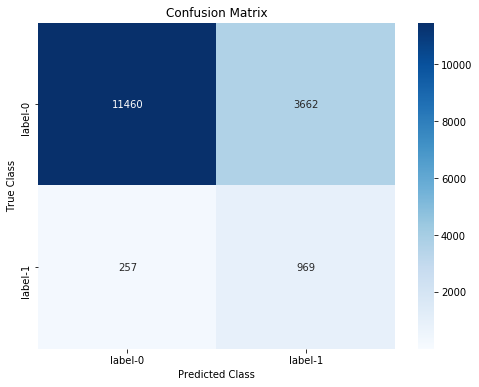

In [74]:
#Confusion Matrix
import seaborn as sns
plt.figure()
cm = confusion_matrix(y_test, preds_model_2)
labels = ['label-0', 'label-1']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

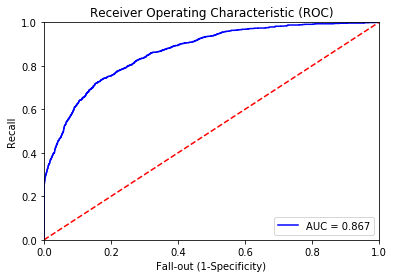

AUC score: 0.8669949338636296


In [75]:
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, preds_model_1)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

## Scoring the model on test_data.csv

In [76]:
#Reading in the prediction dataset
data_predictions = pd.read_csv("test_data.csv")

#Encoding categorical variables
dataset_predictions = pd.get_dummies(data_predictions, columns = ['Sex', 'Race',"DESYNPUF: End stage renal disease Indicator"])


In [77]:
#Storing the encrypted id's seperatly to match back scores after model scoring is done
id_df = data_predictions['ID']
data_predictions = data_predictions.drop(['ID'], axis=1)

print(data_predictions.shape)

(11677, 35)


In [78]:
# Generating the probability scores based on features passed
Scoring_data_Predictions = model_1.predict(dataset_predictions)

In [79]:
# Reattaching the ID column back to probabilities, and sorting the dataset by probablity scores
Scoring_data_Predictions1 = pd.DataFrame(Scoring_data_Predictions)
final_scored_df = pd.concat([id_df, Scoring_data_Predictions1], axis=1)
final_scored_df = final_scored_df.rename(columns={0: "Probability"})
final_scored_df['Rank'] = final_scored_df['Probability'].rank(ascending=False,method='dense')
print(final_scored_df.sort_values('Rank').head(20))

        ID  Probability  Rank
2870  2871  0.989995     1.0 
3104  3105  0.989847     2.0 
2914  2915  0.989847     2.0 
3323  3324  0.989847     2.0 
2891  2892  0.989847     2.0 
3220  3221  0.989847     2.0 
2820  2821  0.989847     2.0 
3146  3147  0.989847     2.0 
3151  3152  0.989847     2.0 
3312  3313  0.989847     2.0 
2825  2826  0.989847     2.0 
2806  2807  0.989847     2.0 
3158  3159  0.989847     2.0 
3018  3019  0.989847     2.0 
2861  2862  0.989847     2.0 
2832  2833  0.989847     2.0 
292   293   0.989834     3.0 
2879  2880  0.989781     4.0 
2951  2952  0.989777     5.0 
2226  2227  0.989666     6.0 


### End